# Modeling Science Education topics over time using Latent Dirichlet Allocation

### Tor Ole B. Odden and Alessandro Marin
### John Rudolph


## I. Introduction: Topic modeling of Science Education papers
In this notebook, we perform a topic analysis of papers from the journal Science Education (formerly General Science Quarterly), which has been publishing articles since 1916. Our method here is based heavily on the analysis published in [Odden, Marin, & Caballero (2020)](https://journals.aps.org/prper/pdf/10.1103/PhysRevPhysEducRes.16.010142).

To do this, we will be using a technique called Latent Dirichlet Allocation, or LDA. LDA is one of a family of machine learning techniques, within the subfield of natural language processing, that analyze text to pull out topics and essential features. Notably, it's a mixed-membership model, which means that it assumes each document will be a mixture of several different topics (the exact number being specified beforehand). Given certain hyperparameters (such as the number of topics and the expected distributions of topics in the different documents), it then attempts to derive the topics from word co-occurrences.

This notebook guides you through the main aspects of the modeling process. To begin with, we have downloaded PDFs of all articles from Science Education/General Science Quarterly, 1916-2019. We have scraped the text from all these PDFs into a dataframe, starting with those from 1922 (papers were missing from 1919-1921, and the text of papers prior to 1919 was heavily corrupted).

Once the text was scraped, we did some basic cleaning on the text: 
* Removing references
* Removing symbols, numbers, and stopwords (such as "and", "is", and "but") 
* Lowercasing all text
* Lemmatizing the text, reducing words to their more basic forms (for example, "testing", "tested", and "tests" to the base word "test")
* Creating bi-grams by uniting words that are commonly used together and which carry a specialized meaning when put together, such as "high_school"
* Turning the text into a series of single words, called "tokens"

In this notebook, we will start by taking our cleaned data and do some filtering, which will improve the quality of our eventual model. This results in the final set of data (a so-called "bag of words") that we use to train the model. We then train a few example models, and compute various measures of quality including coherence, perplexity, and a visual inspection of the most representative papers in each topic. Finally, we use this model to look at the prevalence of topics over time.

### A. Importing Packages

We do our analysis in Python, and we'll need a lot of packages for this analysis. The primary packages we use are Gensim, which is a library used to do this kind of LDA topic modeling. We will also import PyLDAvis, a visualiation package for LDA, and our usual data analysis tools (pandas, matplotlib, numpy) and pickle to store our data for later analysis.

In [1]:
# Print out  all expressions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #default 'last_expr'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>")) 

In [2]:
#Import gensim, our library for text analysis
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Import usual data analysis tools: pandas, matplotlib, and numpy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning);

import os

We have also defines some helper scripts for commonly-used functions like paths to pdfs and stored data files.

## II. Loading in and filtering the data

The datafile we use for this analysis is a pickle file containing processed versions of Science Education papers from 1922 to 2019. There are 5577 articles in this dataset, after some preliminary filtering to remove advertisements and articles with no author. This processed data was then stored in a datafile, which we now load in:

In [3]:
data_words_bigrams = pd.read_pickle('scied_words_bigrams_V5.pkl')

### A. Plotting top words in all documents

Now, we will do some investigation and filtering based on word frequency. Our goal is to filter out the words that occur in a large number of documents, which are less likely to carry any distinct meaning for any specific theories, methods, or research traditions in science education. For example, most people in the science education research community talk about "science", "education", and "students" in one form or another. Those words do not carry a very specialized meaning within the subfield, and so should be removed from our dataset in order to make sure that the more interesting, distinct, and meaningful words are prioritized in the analysis.

We start by defining and importing some more helper functions to plot the word frequency distribution in the dataset.

In [4]:
from helpers import plot_freq_dist,get_top_n_words,plot_words_freq

Total words: 11673326, unique words: 200776


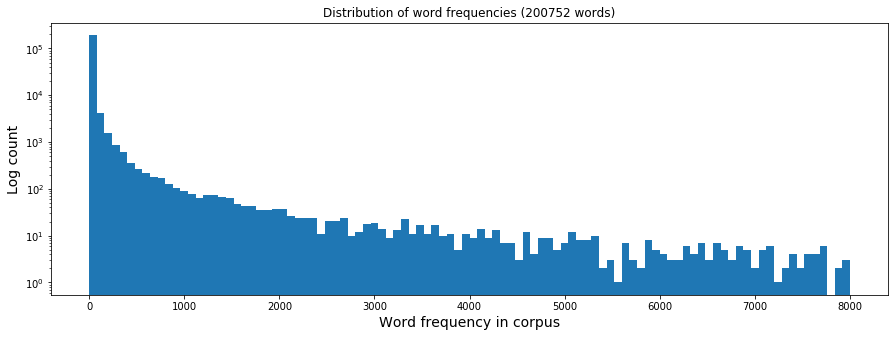

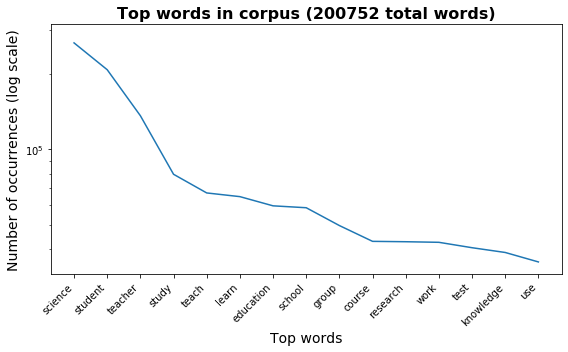

In [5]:
corpus = [ w for doc in data_words_bigrams for w in doc ]
print('Total words: \033[1m%d\033[0m, unique words: \033[1m%d\033[0m' % (len(corpus), len(set(corpus))))

[words, freq, ids] = get_top_n_words(corpus, n_top_words=None)
fig = plot_freq_dist(freq, range=[0,8000])
fig, ax = plot_words_freq(words, freq, 15)

As we can see, the top words in the dataset include "science", "student", "teacher", "study", "teach", "learn", and "education". Because these words are so overrepresented, they need to be filtered out. This is an essential step, since topic models like LDA are based on word co-occurrences, which means that word that are over-represented in the data can wash out the more interesting trends in our data (i.e., words that are theoretically relevant to particular subgroups or research paradgims within science education). 

### B. Creating a Bag of Words to filter the dataset

Thankfully, Gensim already has a built-in function to do this kind of filtering, "filter_extremes", which allows us to filter out words that appear too many or too few times. The parameters are:
* **no_below**: an integer. Keep tokens which are contained in at least no_below documents.  
* **no_above**: a float number between 0 and 1. It filters out tokens which are contained in more than no_above percentage of documents. E.g. with no_above=0.5, tokens in in more than 50% of the documents get cut out.  
* **keep_n**: an integer. It specifies how many tokens should be kept, starting with the most frequent.

However, to use this function we must first create a [Gensim Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary), which is a mapping between each of the entries (i.e. normalized words) and its integer id in the corpus. 

Based on repeated runs with different filtering values, we've set the no_above parameter to 0.50, which filters out 133 words (displayed below). We set our no_below value to 15; this is somewhat arbitrary, but considering the size of the dataset (5577 documents) any words that appear in less than 15 documents are probably not worth keeping—oftentimes they are scanning errors, typos, or names.

After the filtering we convert the remaining tokens into a "bag of words" (BoW). We also display the resulting distribution for the most common words after filtering.

In [6]:
no_below = 15
no_above = 0.5
import copy
id2word_unfiltered_above = gensim.corpora.Dictionary(data_words_bigrams) #Needed for a bug
id2word_unfiltered_above.filter_extremes(no_below=no_below, no_above=1, keep_n=100000)
print("Dictionary with \033[1mno_above=1\033[0m contains \033[1m%d\033[0m unique words\n" % (len(id2word_unfiltered_above)))

id2word = gensim.corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)

#Effect of using no_above
diff_set = set(list(id2word_unfiltered_above.values())) - set(list(id2word.values()))
print("Dictionary filtered with \033[1mno_above=%.2f\033[0m contains \033[1m%d\033[0m unique words. \033[1m%d words\033[0m removed:\n %s \n" % 
      (no_above, len(id2word), len(diff_set), sorted(diff_set)))

Dictionary with no_above=1 contains 25073 unique words

Dictionary filtered with no_above=0.50 contains 24940 unique words. 133 words removed:
 ['ability', 'able', 'activity', 'analysis', 'appear', 'approach', 'area', 'ask', 'attempt', 'base', 'begin', 'case', 'certain', 'change', 'class', 'classroom', 'college', 'come', 'complete', 'concept', 'concern', 'consider', 'content', 'course', 'curriculum', 'data', 'design', 'determine', 'develop', 'developed', 'development', 'difference', 'different', 'discussion', 'education', 'educational', 'effect', 'end', 'evidence', 'example', 'experience', 'fact', 'follow', 'form', 'general', 'give', 'good', 'great', 'group', 'help', 'high', 'high_school', 'idea', 'important', 'include', 'increase', 'indicate', 'individual', 'information', 'ing', 'instruction', 'involve', 'know', 'knowledge', 'large', 'lead', 'learn', 'level', 'life', 'like', 'little', 'major', 'make', 'material', 'mean', 'method', 'nature', 'necessary', 'need', 'new', 'note', 'number'

Unfiltered Dictionary contains 200776 unique words


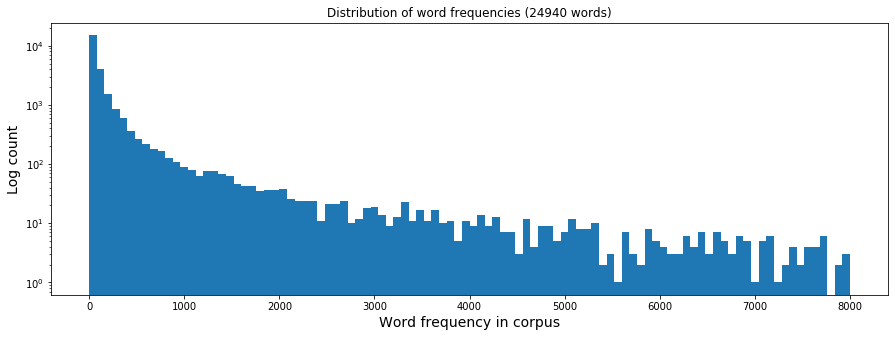

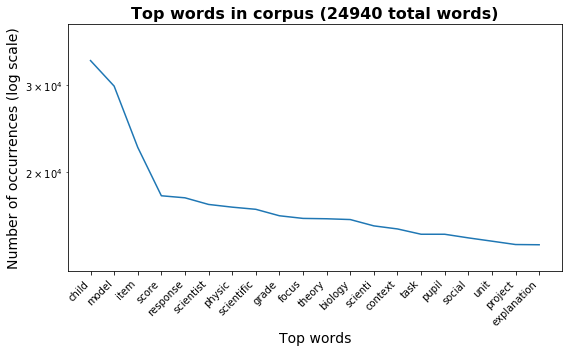

In [7]:
no_below = 15
no_above = 0.5

id2word_unfiltered_above = gensim.corpora.Dictionary(data_words_bigrams) #Needed for a bug
print("Unfiltered Dictionary contains \033[1m%d\033[0m unique words" % len(id2word_unfiltered_above)) #209780

id2word = gensim.corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)

#Create BoW
bow_corpus = [id2word.doc2bow(doc) for doc in data_words_bigrams]

#Get most frequent words from id2word Dictionary
#There is a bug with csf: https://github.com/RaRe-Technologies/gensim/issues/2574
[ids, freq] = zip(*sorted(id2word.cfs.items(), key=lambda x: x[1], reverse=True))
words = [id2word_unfiltered_above[id] for id in ids]  #have to use id2word_unfiltered to retrieve words from ids!!
# Plot distribution
plot_freq_dist(freq, range=[0,8000])
plot_words_freq(words, freq, 20, ylim=None);

## III. Running LDA using Bag of Words

### A. Explanation of LDA

Now, the good part, the topic modeling. To do the modeling, we are using a technique known as Latent Dirichlet Allocation, or LDA. LDA assumes the following generative process for documents: for each document, pick a particular topic according to a certain distribution. Within each topic, pick words based on a particular distribution. The algorithm tries to determine (estimate, fit) these distributions through a stochastic sampling process, based on the co-occurrence of words in the document. It ends up with two things that it estimates: a distribution of topics within each document, and a distribution of words within each topic. In practice, these end up being matrices: one is a document-topic matrix, which has rows corresponding to documents and columns corresponding to the amount of each topic the model predicts is present in each document (dimensions Num_docs x Num_topics). The other is a topic-term matrix, where each row is a topic and each column is a single word from the corpus (dimensions Num_topics x Num_words). Thus, this technique can also be thought of as a kind of probabilistic matrix factorization (see [Hoffman](https://www.researchgate.net/publication/221618332_Online_Learning_for_Latent_Dirichlet_Allocation) for more on this).

The particular distributions depend on parameters that are fed to the model: $\alpha$ tells the model whether is should expect a small number of topics per document (small $\alpha$), vs a larger number in a more even mixture (large $\alpha$). Similarly, $\beta$ is a parameter that controls whether topics have a few central words, or a larger number of more evenly distributed words. Both are based on the [Dirichlet distribution](https://towardsdatascience.com/dirichlet-distribution-a82ab942a879), which essentially is a function that allows you to specify a distribution across a probability simplex (a kind of generalized shape with several “corners”) where the parameter you feed it specifies how likely points are to fall into a specific corner vs. be distributed evenly across the shape. Note, however, that in both of these matrices, each row is a probability distribution across different discrete outcomes (choice of topics or choice of words) and so each row will add up to 1. And, their values will vary considerably. For example, in the topic-word matrix if you had a corpus of 4000 words and every word was equally likely to be chosen for a particular topic, the values in the that row of the (topics x words) matrix would all be 1/4000 = .00025 = 2.5e-4. However, in practice, for particular topics a large number of words will be rated very low, on the order of 1e-6 or 1e-7, while certain other words will be rated highly, on the order of 1e-2 or even higher. It is therefore common when presenting topics to pick the 5-10 most likely words for a particular topic

### B. Training our LDA model

We call the LdaModel function (which does the actual LDA modeling). We pass the following arguments:  
* bow_corpus - our data corpus, in a "bag of words" format  
* num_topics - the number of topics we intend the algorithm to identify. We set this to 10.  
* id2word - the dictionary that maps words to IDs  
* passes - the number of passes the algorithm should take through the data while training
* iterations - the number of iterations the algorithm will use to try to make the results converge

In addition, we pass three other arguments that are particular to the specific model that we are trying to replicate:
* random_state - a random seed value that determines the initialization of the model, which will affect the specific topics it eventually settles on. For the current study, we've determined that a random seed of 29 provides the most stable model.
* alpha - a parameter that determines how mixed the topics are in each document. Gensim has a built-in fuction that can learn alpha values from the corpus as it runs the model, and we'll use this function here.

The output here is a set of topics, each of which contains a set of words with their corresponding weights.

In [8]:
num_topics = 23
#alphatot = 12.5
lda_model = gensim.models.LdaModel(corpus=bow_corpus, 
                                   id2word=id2word, 
                                   num_topics=num_topics,
                                   alpha='auto',
                                   random_state=29, #29 current best, as of 5/6/2020
                                   iterations=15, passes=50)

In [9]:
lda_model.show_topics(num_words=10, num_topics = num_topics)

[(0,
  '0.018*"achievement" + 0.016*"stem" + 0.013*"variable" + 0.013*"girl" + 0.013*"model" + 0.011*"mathematics" + 0.010*"gender" + 0.010*"female" + 0.009*"grade" + 0.009*"woman"'),
 (1,
  '0.052*"book" + 0.038*"text" + 0.030*"textbook" + 0.025*"author" + 0.021*"chapter" + 0.017*"reading" + 0.014*"reader" + 0.010*"review" + 0.010*"new_york" + 0.010*"page"'),
 (2,
  '0.017*"light" + 0.014*"experiment" + 0.012*"water" + 0.012*"observation" + 0.009*"color" + 0.008*"explanation" + 0.007*"go" + 0.007*"observe" + 0.006*"answer" + 0.006*"look"'),
 (3,
  '0.012*"talk" + 0.010*"discourse" + 0.010*"language" + 0.009*"identity" + 0.008*"interaction" + 0.007*"context" + 0.007*"community" + 0.007*"participant" + 0.005*"action" + 0.005*"engage"'),
 (4,
  '0.192*"child" + 0.023*"age" + 0.016*"grade" + 0.014*"object" + 0.010*"parent" + 0.009*"interview" + 0.008*"elementary_school" + 0.008*"year_old" + 0.008*"response" + 0.007*"adult"'),
 (5,
  '0.038*"exhibit" + 0.033*"museum" + 0.026*"visitor" + 0.

As one can see, the output of the LDA model is a set of "topics" (we specified the exact number with the num_topics parameter) each of which is composed of words with specific weights. For the purposes of illustration, we have sorted these topics by their most weighted words: For example, Topic 0 includes the words "achievement", "stem", "variable", "girl", "model", "mathematics" (more words are visible if we increase the num_words parameter in the show_topics method). It's helpful here to remember that from a statistical perspective, each of these topics is essentially a distribution over all of the words in the data corpus, which tells us how likely one would be to draw a particular word, given a particular topic, in the generative process for documents that LDA assumes (described above).

These words and weights are one of the main outputs of this model. However, it's up to the researcher to figure out what each topic means based on these words. For example, since Topic 0 includes words related to gender, achievement, and stem, we interpret it as a topic about Gender, Race, and the STEM Pipeline.

One can get the entire distribution using the "get_topics()" method. For example, here is the vector for topic 8, along with the lowest and highest values.

In [10]:
print("Distribution vector for topic 0: ", lda_model.get_topics()[0], "\n")

print("Maximum value: {} corresponding to the word {}".format(np.amax(lda_model.get_topics()[0]), id2word[np.argmax(lda_model.get_topics()[8])]))
print("Minimum value: {} corresponding to the word {}".format(np.amin(lda_model.get_topics()[0]), id2word[np.argmin(lda_model.get_topics()[8])]))

Distribution vector for topic 0:  [4.4405646e-05 1.2980232e-07 1.2980232e-07 ... 1.2980242e-07 1.2980236e-07
 1.2980236e-07] 

Maximum value: 0.017832281067967415 corresponding to the word social
Minimum value: 1.298023164508777e-07 corresponding to the word ab


The maximum value was around 0.017, which corresponds to the word "social". The lowest value is 1.29e-7, corresponding to the word "ab". Thus, in the "draw a topic/draw a word" process described above, one would be roughly 132,000 times more likely to draw the word social than to draw the word ab.

One can also start to associate specific themes with each set of topics. For example, Topic 0 focuses on gender and the STEM pipeline; Topic 1 focuses on textbooks and book reviews; Topic 2 focuses on light and observation; and Topic 3 focuses on discourse analysis and identity.

### C. Evaluating models with perplexity and coherence scores
We can evaluate the "goodness" of our topic models using two measures, perplexity and coherence score. Perplexity is essentially a statistical measure of the log probability of unseen test documents fitting into the model (based on the geometric mean of the per-word likelihood). It’s useful for selecting a model but not so useful for topic evaluation since it has been shown to be uncorrelated with human interpretability (Newman et al., 2010). For this reason, coherence is more often used. Coherence measures the degree of semantic similarity between high scoring words in the topic—in other words, are these words roughly being used the same, based on the other words they appear with? These measurements help distinguish between topics that are semantically interpretable ("hang together") and topics that are artifacts of the statistical process LDA uses (Röder, Both, and Hinneburg, 2015).

For the purposes of illustration, we compute both the perplexity and the coherence on the topics we've found. Perplexity is a score in the range from -14 to 14, with lower perplexity being better. Coherence ranges from 0-1, with higher scores being better. We have typically found coherence scores between 0.4-0.53, which stackexchange informs us is okay but not great. We suspect this is because our data is relatively homogeneous—that is, all documents are on variations of topics related to science education, so it's hard to get extremely distinct topics. If, instead, we were analyzing a mixture of documents about 3 distinct subjects (say, sports, religion, and technology companies) we might expect more distinct topics with less overlap and a higher overall coherence.

In [11]:
#Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_lda = gensim.models.CoherenceModel(model=lda_model, 
                                             texts=data_words_bigrams, 
                                             dictionary=id2word, 
                                             coherence='c_v',
                                             topn=20).get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -9.319074187975692

Coherence Score:  0.5228181280622161


Of these two measures, both we and the literature (e.g., Röder, Both, and Hinneburg, 2015) have found coherence to be more useful for predicting interpretable topics so we have used it in making decisions about our model. As one can see, this particular model is on the high end of our observed coherence score range (0.522). 

## IV. Results of the model: Visualization, representative papers, and prevalence of topics over time

### A. Visualizing the model

With this model trained, we can use it to explore a variety of different aspects of the resulting topics and their relation to the literature. First, we can use the pyLDAvis package to visualize the topics and see how distinct they are from one another in a 2D space created by principle component analysis on the word space. By mousing over the resulting visual, you can see the different topics, their prevalence (indicated by the size of the circles), the most salient terms in each, and their rough inter-topic "distance."

In [12]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word, n_jobs=1) 
pyLDAvis.display(vis)

Sometimes it's possible to see a structure in this 2D space, but it's hard to tell if there's anything here. This may be because this is a 2D slice of an inherently higher-dimensional space, and so this slice may not encompass all that much of the variance in that space. However, we can use this to check if there are any outlying topics that seem to be skewing our model—these will show up as major outliers in the plot. No such outliers are visible here, so that's a good sign.

One can also get a feel for the "market share" of each of these topics, based on the size of each circle. Note that the smaller circles tend to be topics about specific types of science content. As we'll see later, these tend to have lower prevalence overall.

### B. Explaining the PCA variance of pyLDAvis

One interesting question (relevant if we are to take these interpretations seriously) is how much of the variance is encapsulated by the principle component analysis (PCA) used in pyLDAvis. Although there isn't a direct way to make the function output this number, by looking over the [pyLDAvis pcoa documentation](https://pyldavis.readthedocs.io/en/latest/_modules/pyLDAvis/_prepare.html#js_PCoA) and another [script referenced in that documentation](https://github.com/biocore/scikit-bio/blob/0.5.0/skbio/stats/ordination/_principal_coordinate_analysis.py) we've been able to re-create the functions used for the PCA.

In [13]:
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform

def jensen_shannon(P, Q):
    M = 0.5 * (P + Q)
    return 0.5 * (entropy(P, M) + entropy(Q, M))

def pcoa(pair_dists, n_components=2):
    """Principal Coordinate Analysis,
    aka Classical Multidimensional Scaling
    """
    # code referenced from skbio.stats.ordination.pcoa
    # https://github.com/biocore/scikit-bio/blob/0.5.0/skbio/stats/ordination/_principal_coordinate_analysis.py

    # pairwise distance matrix is assumed symmetric
    pair_dists = np.asarray(pair_dists, np.float64)

    # perform SVD on double centred distance matrix
    n = pair_dists.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = - H.dot(pair_dists ** 2).dot(H) / 2
    eigvals, eigvecs = np.linalg.eig(B)

    # Take first n_components of eigenvalues and eigenvectors
    # sorted in decreasing order
    ix = eigvals.argsort()[::-1]
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    # replace any remaining negative eigenvalues and associated eigenvectors with zeroes
    # at least 1 eigenvalue must be zero
    eigvals[np.isclose(eigvals, 0)] = 0
    if np.any(eigvals < 0):
        ix_neg = eigvals < 0
        eigvals[ix_neg] = np.zeros(eigvals[ix_neg].shape)
        eigvecs[:, ix_neg] = np.zeros(eigvecs[:, ix_neg].shape)
        
    proportion_explained = eigvals / eigvals.sum()

    return np.sqrt(eigvals) * eigvecs, proportion_explained

def js_PCoA(distributions):
    """Dimension reduction via Jensen-Shannon Divergence & Principal Coordinate Analysis
    (aka Classical Multidimensional Scaling)

    Parameters
    ----------
    distributions : array-like, shape (`n_dists`, `k`)
        Matrix of distributions probabilities.

    Returns
    -------
    pcoa : array, shape (`n_dists`, 2)
    """
    dist_matrix = squareform(pdist(distributions, metric=jensen_shannon))
    return pcoa(dist_matrix)

In [14]:
jspcoa, explained = js_PCoA(lda_model.get_topics()) #run PCoA on the normalized topic vectors
print('Variance explained by PC1: {0:.2f} percent'.format(explained[0]*100))
print('Variance explained by PC2: {0:.2f} percent'.format(explained[1]*100))
print('Total variance explained: {0:.2f} percent'.format((explained[0]+explained[1])*100))

Variance explained by PC1: 14.96 percent
Variance explained by PC2: 12.54 percent
Total variance explained: 27.50 percent


In this case, the total variance explained by the two dimensions plotted above cover only roughly 1/4 of the total. So, this supports our assertion that the higher-dimensional space is rather complex and difficult to display using only a 2D slice.

### C. Dominant topic in each document

We can also use this model to make an estimation of the document-topic distribution; that is, for a particular document, find out how much the model associates it with each topic.

In [15]:
def get_weight_in_doc(ldamodel, corpus, doc_num, fill=0):
    """ Get the weigth for each topic in a document
    Inputs: ldamodel, corpus, doc_num, fill (value when topic was not found)
    Output: list of tuples [(<topic number>, <topic weight>)]
    """
    num_topics = ldamodel.num_topics
    weights = [fill] * num_topics
    # Get a list of tuples with the detected topics and weights
    row = ldamodel[corpus][doc_num]
    # Process the output to return a list of weights
    tw = list(zip(*row))
    for topic in range(num_topics):
        if topic in tw[0]:
            ind = tw[0].index(topic)
            weights[topic] = tw[1][ind]
    return weights

def get_weight_per_doc(ldamodel, corpus):
    """ Get a document by topic weight Dataframe 
    Inputs: ldamodel, corpus
    """
    num_topics = ldamodel.num_topics
    dataframe = pd.DataFrame(np.zeros((len(corpus),num_topics)), columns=list(range(num_topics)))
    dataframe.index.name = 'Topic weights'
    for i, row in dataframe.iterrows():
        dataframe.iloc[i] = pd.Series(get_weight_in_doc(ldamodel, corpus, i))
    return dataframe

weights = get_weight_per_doc(lda_model, bow_corpus)

In [16]:
display(weights.head().round(decimals=2))

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
Topic weights,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.02,0.01,0.0,0.01,0.00,0.00,0.00,0.04,...,0.0,0.0,0.15,0.0,0.0,0.36,0.00,0.36,0.0,0.0
1,0.0,0.0,0.02,0.00,0.0,0.03,0.04,0.00,0.00,0.00,...,0.0,0.0,0.20,0.0,0.0,0.29,0.00,0.39,0.0,0.0
2,0.0,0.0,0.31,0.00,0.0,0.00,0.23,0.00,0.00,0.00,...,0.0,0.0,0.00,0.0,0.0,0.40,0.00,0.05,0.0,0.0
3,0.0,0.0,0.02,0.00,0.0,0.00,0.03,0.02,0.03,0.00,...,0.0,0.0,0.00,0.0,0.0,0.82,0.01,0.03,0.0,0.0
4,0.0,0.0,0.10,0.00,0.0,0.00,0.13,0.00,0.00,0.00,...,0.0,0.0,0.00,0.0,0.0,0.56,0.00,0.14,0.0,0.0


Now, we can associate each weight with its respective document, and see how the  model classifies them. For the purposes of simplicity (and to save space in an already-long notebook) we've created a separate datafile with these model weights and our chosen topic names, organized in the order that we present these topics in our article. For each paper, we also provide the year, title, authors, and DOI. We'll import this datafile here. However, the code above can be used to re-create this datafile (minus the topic names and in the order the appeared in the model) in combination with the commented code below. This might be useful if you start changing the number of topics, filtering parameters, or random seed of the lda_model function above (which will change/scramble the topics it produces compared to our presented model). 

In [30]:
# Load the DataFrame with processed text
df = pd.read_pickle('SciEd_paper_names_weights.pkl')

In [31]:
#Code to reconstruct a datafile with the assigned model weights for each paper

#modeldf = df.loc[:, ['year','title','authors','DOI']] #drop all columns except the date
#modeldf = pd.concat([modeldf, weights], axis = 1) #append the weights
#modeldf.head()

**Note: from here on out we will be using the topic names and numbers from our paper, not our model.**
If you want to match the topics generated by our model over to those used in our paper (and the datafile we've imported) you can use the following two scripts. The first is a list of names for each topic (and the number used in the paper) which can easily be used as a reference or turned into a dictionary. The second is a list with the topic numbers from the model, in the order we present them in the paper. So, for example, the 18th topic produced by the model is, in the paper, "Topic 1. Science in Everyday Life".

In [32]:
#topic keywords: sorted by topic z
topic_keys = [
    '20. Gender, Race, and the STEM Pipeline',
    'Journal Business', 
    '5. Light and Observation',
    '21. Identities and Discourse Analysis',
    '14. Children’s Ideas',
    '13. Science Learning in Museums and Other Informal Settings',
    '3. Physical Science',
    '18. Cognitive Models and Representations',
    '10. Science-Technology-Society, Socioscientific and Cultural Issues',
    '11. History and Philosophy of Science',
    '2. Earth and Space Science',
    '15. Quantitative Measures of Student Performance',
    '4. Biological Science',
    '9. Inquiry-Based Instruction and Research Experiences',
    '17. Quantitative Methods, and Assessment of Student Interest and Motivation',
    'Professional Matters', 
    '12. Teacher Professional Development and Science Teacher Education',
    '8. Physics Education and Laboratory Instruction',
    '1. Science in Everyday Life',
    '16. Educational Psychology and Problem-Solving',
    '6. Science Teacher Preparation, Program Development, and Technology',
    '7. Science Teacher Training and Content Preparation',
'19. Argumentation']

#List of the topics generated by our model, in the order that we present them in the paper
topic_order_list = [18,10,6,12,2,20,21,17,13,8,9,16,5,4,11,19,14,7,22,0,3,1,15]

Now, we go back to our chosen model and display the weights the model assigns to each paper. Basically, this can be thought of as a percent measure of how much of each topic is in that paper. This analysis, for example, says that the 2020 paper "The effect of first high school science teacher's gender and gender matching on students' science identity in college" by Chen et al. is 66% Topic 20 (Gender, Race, and the STEM Pipeline; words: achievement, stem, variable, girl, model, mathematics, gender, female, grade, woman, career), and another 10% about Topic 21 (Identities and Discourse Analysis). This makes sense, since the paper is about the effects of teacher gender and gender matching on students' science identities in college.

In [33]:
#Display examples
pd.set_option('display.max_columns', None)
df.tail().round(decimals=2)

,year,title,authors,DOI,1. Science in Everyday Life,2. Earth and Space Science,3. Physical Science,4. Biological Science,5. Light and Observation,"6. Science Teacher Preparation, Program Development, and Technology",7. Science Teacher Training and Content Preparation,8. Physics Education and Laboratory Instruction,9. Inquiry-Based Instruction and Research Experiences,"10. Science-Technology-Society, Socioscientific and Cultural Issues",11. History and Philosophy of Science,12. Teacher Professional Development and Science Teacher Education,13. Science Learning in Museums and Other Informal Settings,14. Children’s Ideas,15. Quantitative Measures of Student Performance,16. Educational Psychology and Problem-Solving,"17. Quantitative Methods, and Assessment of Student Interest and Motivation",18. Cognitive Models and Representations,19. Argumentation,"20. Gender, Race, and the STEM Pipeline",21. Identities and Discourse Analysis,Journal Business,Professional Matters
5572,2020,The mangle of school science practice: Teacher...,"Leden L, Hansson L, Ideland M",10.1002/sce.21553,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.06,0.08,0.07,0.14,0.02,0.00,0.00,0.0,0.02,0.00,0.03,0.34,0.00,0.22,0.00,0.0
5573,2020,Using historical and political understanding t...,"Shea MV, Sandoval J",10.1002/sce.21555,0.06,0.00,0.0,0.00,0.1,0.0,0.00,0.00,0.07,0.29,0.00,0.00,0.03,0.02,0.0,0.00,0.00,0.00,0.02,0.00,0.39,0.00,0.0
5574,2020,What influences development of science content...,"Judson E, Hayes KN, Glassmeyer K",10.1002/sce.21549,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.56,0.05,0.04,0.03,0.00,0.00,0.0,0.00,0.11,0.01,0.12,0.04,0.02,0.00,0.0
5575,2020,The effect of first high school science teache...,"Chen C, Sonnert G, Sadler PM",10.1002/sce.21551,0.00,0.00,0.0,0.02,0.0,0.0,0.06,0.06,0.02,0.01,0.01,0.00,0.00,0.00,0.0,0.00,0.02,0.01,0.00,0.66,0.10,0.00,0.0
5576,2020,A deficit in shared practice: Reflections on L...,"Furtak EM, Stroupe D",10.1002/sce.21556,0.03,0.06,0.0,0.00,0.0,0.0,0.00,0.00,0.01,0.49,0.09,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.10,0.02,0.14,0.02,0.0


We can also search for individual authors. For example, here's the classification for all papers authored by Rudolph, JL since 1995:

In [34]:
name = 'Rudolph'
date = 1995

df[df['authors'].str.contains(name) & (df['year'] > date)].round(decimals=2)

,year,title,authors,DOI,1. Science in Everyday Life,2. Earth and Space Science,3. Physical Science,4. Biological Science,5. Light and Observation,"6. Science Teacher Preparation, Program Development, and Technology",7. Science Teacher Training and Content Preparation,8. Physics Education and Laboratory Instruction,9. Inquiry-Based Instruction and Research Experiences,"10. Science-Technology-Society, Socioscientific and Cultural Issues",11. History and Philosophy of Science,12. Teacher Professional Development and Science Teacher Education,13. Science Learning in Museums and Other Informal Settings,14. Children’s Ideas,15. Quantitative Measures of Student Performance,16. Educational Psychology and Problem-Solving,"17. Quantitative Methods, and Assessment of Student Interest and Motivation",18. Cognitive Models and Representations,19. Argumentation,"20. Gender, Race, and the STEM Pipeline",21. Identities and Discourse Analysis,Journal Business,Professional Matters
4494,2001,Considering the nature of scientific problems ...,"Stewart J, Rudolph JL",10.1002/sce.1006,0.00,0.0,0.0,0.16,0.03,0.0,0.0,0.00,0.01,0.02,0.19,0.04,0.0,0.00,0.0,0.05,0.00,0.31,0.15,0.0,0.01,0.00,0.00
4588,2003,Portraying epistemology: School science in his...,Rudolph JL,10.1002/sce.1055,0.02,0.0,0.0,0.00,0.00,0.0,0.0,0.01,0.01,0.30,0.41,0.00,0.0,0.00,0.0,0.00,0.00,0.04,0.14,0.0,0.01,0.00,0.01
4590,2003,Some thoughts on portraying epistemology in to...,Rudolph JL,10.1002/sce.10068,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.03,0.29,0.43,0.00,0.0,0.00,0.0,0.00,0.00,0.02,0.19,0.0,0.03,0.00,0.00
4660,2004,Science education as/for sociopolitical action,Rudolph JL,10.1002/sce.10137,0.02,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.04,0.43,0.04,0.02,0.0,0.01,0.0,0.00,0.03,0.00,0.13,0.0,0.12,0.13,0.00
4757,2005,"Inquiry, instrumentalism, and the public under...",Rudolph JL,10.1002/sce.20071,0.02,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.11,0.40,0.19,0.00,0.0,0.00,0.0,0.02,0.00,0.04,0.16,0.0,0.03,0.01,0.00
4834,2006,Guest editorial: Science studies and science e...,"Duschl R, Erduran S, Grandy R, Rudolph J",10.1002/sce.20187,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.08,0.32,0.23,0.00,0.0,0.00,0.0,0.03,0.00,0.01,0.19,0.0,0.03,0.07,0.03
4922,2008,Introduction to special issue: Science Studies...,"Duschl R, Erduran S, Grandy R, Rudolph J",10.1002/sce.20271,0.00,0.0,0.0,0.00,0.01,0.0,0.0,0.00,0.05,0.30,0.14,0.01,0.0,0.00,0.0,0.00,0.00,0.06,0.25,0.0,0.07,0.07,0.03


There's a definite tendency towards Topic 10 (which seems to be about Science-Technology-Society), topic 11 (History and Philosophy of Science), and a smaller association with Topic 19 (Argumentation). This makes sense, since John writes a lot about history of science and the connections between science education and society more generally.

Using this set of weights, we can make a plot of the topic weight (in a percent) by document number. Although this plot is quite messy, the dots above 0.5 on the y-axis show that there are lots of documents that fall more than 50% into a particular topic, and the color shifts show definite rise and fall of different topics over time.

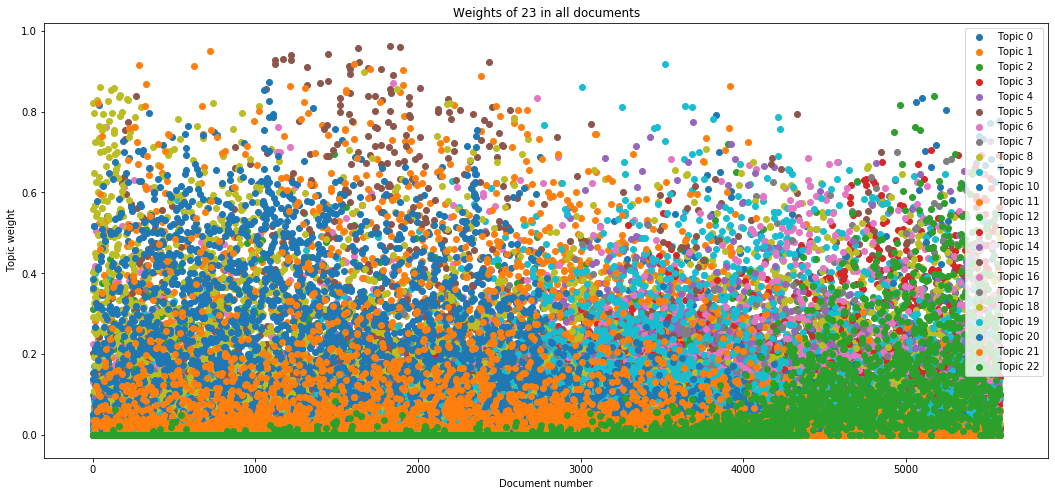

In [35]:
plt.figure(figsize=(18, 8))
for t in range(num_topics):
    plt.scatter(weights.index, weights.iloc[:,t], label='Topic '+str(t))
plt.xlabel("Document number")
plt.ylabel("Topic weight")
plt.legend(loc='upper right')
plt.title('Weights of %d in all documents' % num_topics)
plt.show();

### D. Most representative documents for each topic

We can also go through, topic-by-topic, and find the most representative documents for each topic, which can be useful both for verifying that these topic groupings make sense and to characterize each topic:

In [36]:
num_docs = 10

try:
    #Show tables in plotly if plotly is installed
    import plotly.graph_objects as go
    for t in df.columns[4:]:
        content = df.sort_values(by=t, ascending=False)[['year','title','authors',t]][:num_docs]
        fig = go.Figure(data=[ go.Table(
            columnwidth = [60, 40, 40, 300, 220],
            header=dict(
                values=['<b>Document number</b>', '<b>Weight</b>', '<b>Year</b>', '<b>Title</b>', '<b>Authors</b>'],
                height=48,
                font_size=14,
                line_color='black',
                fill_color='lightgrey'),
            cells=dict(
                values=[list(content.index), list(round(content[t],2)), list(content.year), list(content.title), list(content.authors)],
                align=['center', 'center', 'center', 'left', 'left'],
                height=48,
                font_size=12,
                line_color='black',
                fill_color='white')) ])
        fig.update_layout( title_text=t)
    del content
    
except: 
    #Show basic tables if Plotly isn't installed
    pd.set_option('display.max_colwidth', 150)
    for t in df.columns[4:]:
        df.sort_values(by=t, ascending=False)[['year','title','authors',t]][:num_docs]
        print('\n\n')

### E. Time plot of topic weights

Finally, we can plot the "prevalence" of each topic as a function of time. That is, for each year we can add up the percentage of each topic in each document from that year's Science Education articles (normalized by the number of documents) and plot that as a function of time. Intuitively, we can think of this "prevalence" as being a measure of the percentage of papers published on that topic in that year, found by adding up the fractional topic contributions from each paper each year.

It can, however, be tricky to see overall trends with so much year-to-year variation. So, in the next plots we have implemented a smoothing function in the form of a average across a 3-year rolling window. This effectively serves to dampen out small variations, while leaving larger trends intact. However, it also neglects the first and last years.

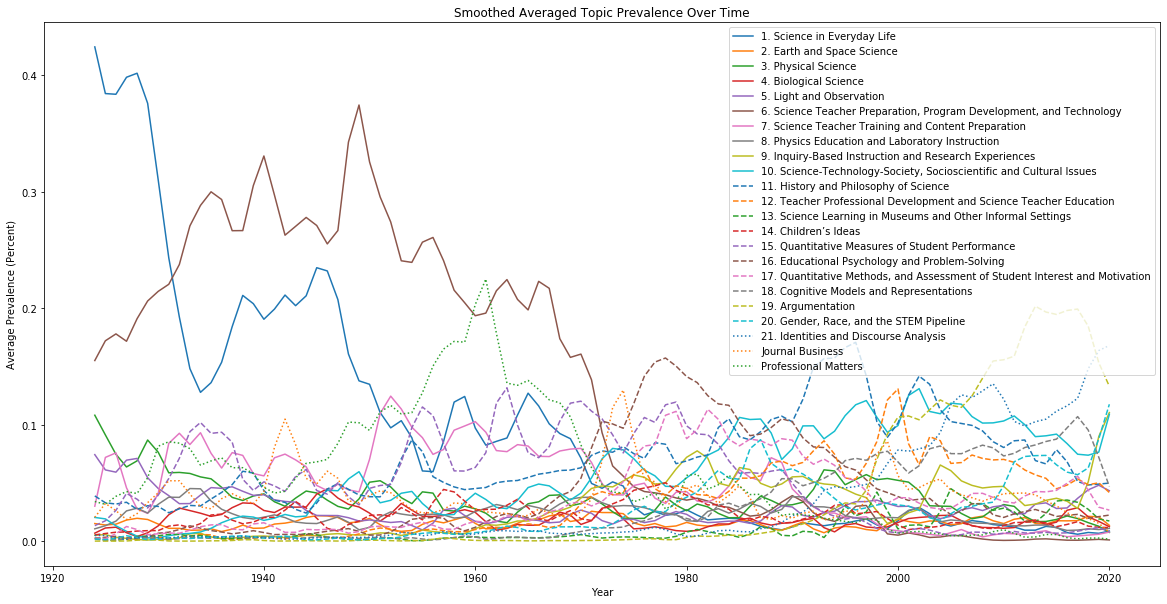

In [37]:
meanplot = df.groupby('year').agg('mean').rolling(3, min_periods=3, win_type='triang').mean().plot(
    kind='line', figsize=(20,10), title='Smoothed Averaged Topic Prevalence Over Time');

#meanplot.legend(["Representations", "Problem Solving","Labs","Assessment","K12","Quantum","Community, Identity","Energy","Tutorial","Survey"])
meanplot.set_xlabel("Year")
meanplot.set_ylabel("Average Prevalence (Percent)")

[line.set_linestyle('--') for i, line in enumerate(meanplot.lines) if i > 9]
[line.set_linestyle(':') for i, line in enumerate(meanplot.lines) if i > 19]
meanplot.legend();

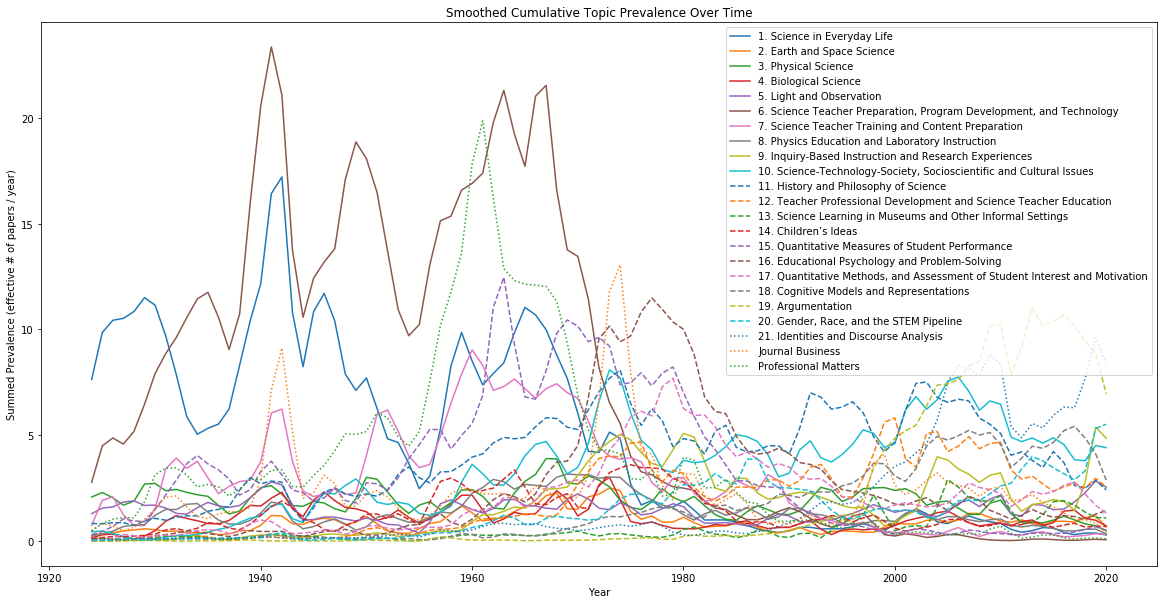

In [38]:
sumplot = df.groupby('year').agg('sum').rolling(3, min_periods=3, win_type='triang').mean().plot(
    kind='line', figsize=(20,10), title='Smoothed Cumulative Topic Prevalence Over Time')

#sumplot.legend(["Representations", "Problem Solving","Labs","Assessment","K12","Quantum","Community, Identity","Energy","Tutorial","Survey"])
sumplot.set_xlabel("Year")
sumplot.set_ylabel("Summed Prevalence (effective # of papers / year)")

[line.set_linestyle('--') for i, line in enumerate(sumplot.lines) if i > 9]
[line.set_linestyle(':') for i, line in enumerate(sumplot.lines) if i > 19]
sumplot.legend();

Here, we can see that there are definite trends over time. For example, there's an early focus on topic 1, which is about science in everyday life, but it decays rapidly. Prior to 1970 there's also big focus on topic 6, which is a general topic on science teacher preparation, program development, and educational technology.

Another way to look at this is by just adding up the fractional contributions of papers, without averaging. This means that the graph will be more sentitive to year-to-year variations in numbers of articles published, but that provides some interesting information too. Here, the y-axis can be interpreted as a measure of the total number of papers published a topic each year.

### F. Interactive graphs with plotly

If you have plotly installed, the commented code below can be used to generate interactive versions of the graphs above. On these graphs, you can click on particular traces in the legend to remove them (or add them back in) and double click on traces to remove everything but that trace from the graph. The axes also rescale dynamically based on the traces.

In [39]:
"""
import plotly
import plotly.express as px
import textwrap

#Create the dataset to be graphed in plotly
plotlydata = df.groupby('year').agg('mean').rolling(3, min_periods=3, win_type='triang').mean().dropna()
plotlydata['Years'] = plotlydata.index.values
plotlydata = plotlydata[plotlydata['Years']<2020]

#Create the reshaped dataframe necessary for plotly express
tidy_df = plotlydata.melt(id_vars="Years", var_name = "Topic", value_name = "Prevalence (percent)") 

#Create and fill in the words for each topic, to be displayed on the mouse-over on the graph
tidy_df['words'] = ''
tidy_df['topic num'] = 0

#Create the formatted list of words, and put them into the dataframe
for t in topic_order_list:
    formattedlist = [topic[0] for topic in lda_model.show_topics(num_topics = 25, formatted=False, num_words = 5)[t][1]]
    tidy_df.loc[tidy_df['Topic'] == topic_keys[t], 'words'] = ', '.join(formattedlist)

#Graph the traces and show the figure
fig = px.line(tidy_df, x="Years", y="Prevalence (percent)", color='Topic', line_dash = "Topic", 
              hover_data = ['words'], title = 'Average Topic Prevalence over Time', width=1600, height=800)

fig.show()
"""

'\nimport plotly\nimport plotly.express as px\nimport textwrap\n\n#Create the dataset to be graphed in plotly\nplotlydata = df.groupby(\'year\').agg(\'mean\').rolling(3, min_periods=3, win_type=\'triang\').mean().dropna()\nplotlydata[\'Years\'] = plotlydata.index.values\nplotlydata = plotlydata[plotlydata[\'Years\']<2020]\n\n#Create the reshaped dataframe necessary for plotly express\ntidy_df = plotlydata.melt(id_vars="Years", var_name = "Topic", value_name = "Prevalence (percent)") \n\n#Create and fill in the words for each topic, to be displayed on the mouse-over on the graph\ntidy_df[\'words\'] = \'\'\ntidy_df[\'topic num\'] = 0\n\n#Create the formatted list of words, and put them into the dataframe\nfor t in topic_order_list:\n    formattedlist = [topic[0] for topic in lda_model.show_topics(num_topics = 25, formatted=False, num_words = 5)[t][1]]\n    tidy_df.loc[tidy_df[\'Topic\'] == topic_keys[t], \'words\'] = \', \'.join(formattedlist)\n\n#Graph the traces and show the figure\nfi

In [40]:
"""
#Create the dataset to be graphed in plotly
plotlydata = df.groupby('year').agg('sum').rolling(3, min_periods=3, win_type='triang').mean().dropna()
plotlydata['Years'] = plotlydata.index.values
plotlydata = plotlydata[plotlydata['Years']<2020]

#Create the reshaped dataframe necessary for plotly express
tidy_df = plotlydata.melt(id_vars="Years", var_name = "Topic", value_name = "Cumulative Documents") 

#Create and fill in the words for each topic, to be displayed on the mouse-over on the graph
tidy_df['words'] = ''
tidy_df['topic num'] = 0

#Create the formatted list of words, and put them into the dataframe
for t in topic_order_list:
    formattedlist = [topic[0] for topic in lda_model.show_topics(num_topics = 25, formatted=False, num_words = 5)[t][1]]
    tidy_df.loc[tidy_df['Topic'] == topic_keys[t], 'words'] = ', '.join(formattedlist)

#Graph the traces and show the figure
fig = px.line(tidy_df, x="Years", y="Cumulative Documents", color='Topic', line_dash = "Topic", 
              hover_data = ['words'], title = 'Cumulative Topic Prevalence over Time', width=1600, height=800)

fig.show()
"""

'\n#Create the dataset to be graphed in plotly\nplotlydata = df.groupby(\'year\').agg(\'sum\').rolling(3, min_periods=3, win_type=\'triang\').mean().dropna()\nplotlydata[\'Years\'] = plotlydata.index.values\nplotlydata = plotlydata[plotlydata[\'Years\']<2020]\n\n#Create the reshaped dataframe necessary for plotly express\ntidy_df = plotlydata.melt(id_vars="Years", var_name = "Topic", value_name = "Cumulative Documents") \n\n#Create and fill in the words for each topic, to be displayed on the mouse-over on the graph\ntidy_df[\'words\'] = \'\'\ntidy_df[\'topic num\'] = 0\n\n#Create the formatted list of words, and put them into the dataframe\nfor t in topic_order_list:\n    formattedlist = [topic[0] for topic in lda_model.show_topics(num_topics = 25, formatted=False, num_words = 5)[t][1]]\n    tidy_df.loc[tidy_df[\'Topic\'] == topic_keys[t], \'words\'] = \', \'.join(formattedlist)\n\n#Graph the traces and show the figure\nfig = px.line(tidy_df, x="Years", y="Cumulative Documents", color=

For the purposes of simplicity (and in case one doesn't have Plotly installed), we've saved these graphs to HTML files, and embedded them in the cells below:

In [43]:
from IPython.display import IFrame
IFrame(src='AvgPrev.html', width=1600, height=800)

In [44]:
IFrame(src='CumuPrev.html', width=1600, height=800)

Although the plot is somewhat crowded, there are many interesting patterns you can find here. For example, the low prevalence of content-related topics (1-5) except for 1. Science in Everyday Life; the rise of educational psychology-inspired topics in the 1970s (16 and 17); the shift in models of teacher training/professional development (7 and 12); the recent shift towards scientific practices and identity (19 and 21); and the shift from cognitivist frameworks to sociocultural frameworks (16, 17, 18, and 21).

Go ahead and play with the graphs, see if you see any interesting trends for yourself!

## V. Conclusions

In conclusion, we are able to see some interesting trends over time here. We are still working on understanding where these trends might come from. More to come on this soon, both in our paper and in future studies!

# References

1. Odden, T. O. B., Marin, A., & Caballero, M. D. (2020). Thematic Analysis of 18 Years of Physics Education Research Conference Proceedings using Natural Language Processing. Physical Review Physics Education Research, 16(1), 10142. https://doi.org/10.1103/PhysRevPhysEducRes.16.010142
2. Hoffman, M. D., Blei, D. M. & Bach, F. Online Learning for Latent Dirichlet Allocation (Supplementary Material). Nature 0, 1–9 (2010).
3. Newman, D., Lau, J. H., Grieser, K. & Baldwin, T. Automatic evaluation of topic coherence. in NAACL HLT 2010 - Human Language Technologies: The 2010 Annual Conference of the North American Chapter of the Association for Computational Linguistics, Proceedings of the Main Conference 100–108 (2010).
4. Röder, M., Both, A. & Hinneburg, A. Exploring the space of topic coherence measures. WSDM 2015 - Proc. 8th ACM Int. Conf. Web Search Data Min. 399–408 (2015). doi:10.1145/2684822.2685324